# Projection Examples

In [1]:
%load_ext autoreload
%autoreload 2

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
from IPython.display import display

from htc import Config, DataPath, DatasetImage, LabelMapping, median_table, settings
from htc.models.common.transforms import Normalization
from htc.tivita.rgb import hsi_to_rgb
from htc_projects.species.ProjectionLearner import ProjectionLearner

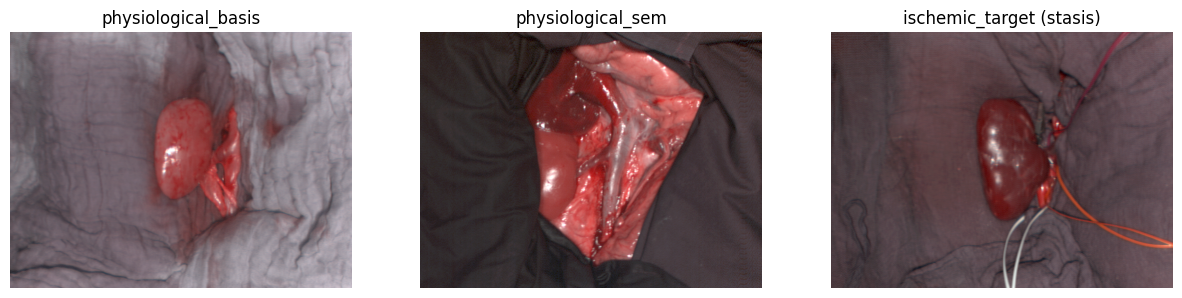

In [2]:
df = median_table(dataset_name="2023_04_22_Tivita_multiorgan_kidney", annotation_name="semantic#primary")
df = df.query("label_name == 'kidney'")

path_p = DataPath.from_image_name("P079#2021_02_11_20_34_44#overlap@semantic#primary")
path_p2 = DataPath.from_image_name("P058#2020_05_13_19_06_35")
path_i = DataPath.from_image_name("P095#2021_05_02_13_49_47")

# The optimization is done on L1 normalized spectra so we keep track of the original counts for RGB visualization
norm_counts_p = np.sum(np.abs(path_p.read_cube()), axis=-1)
norm_counts_p2 = np.sum(np.abs(path_p2.read_cube()), axis=-1)
norm_counts_i = np.sum(np.abs(path_i.read_cube()), axis=-1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(path_p.read_rgb_reconstructed())
ax1.set_title("physiological_basis")
ax1.set_axis_off()
ax2.imshow(path_p2.read_rgb_reconstructed())
ax2.set_title("physiological_sem")
ax2.set_axis_off()
ax3.imshow(path_i.read_rgb_reconstructed())
ax3.set_title(f"ischemic_target ({path_i.meta('phase_type')})")
ax3.set_axis_off()

In [3]:
df.groupby(["phase_type", "phase_time"], as_index=False)["image_name"].nunique()

phase_type  phase_time  image_name
0   avascular         0.0           2
1   avascular         0.5          15
2   avascular         1.0          32
3   avascular         1.5          25
4   avascular         2.0          18
5   avascular         2.5           6
6   avascular         3.0           4
7   avascular         3.5           1
8   avascular         4.0           2
9    ischemia         0.5          11
10   ischemia         1.0          30
11   ischemia         1.5          32
12   ischemia         2.0          17
13   ischemia         2.5           7
14   ischemia         3.0           4
15   ischemia         3.5           2
16   ischemia         4.0           1
17   ischemia         4.5           1
18     stasis         0.5           1
19     stasis         1.0          19
20     stasis         1.5          33
21     stasis         2.0          12
22     stasis         2.5           4
23     stasis         3.0           2

In [4]:
with pd.option_context("display.max_colwidth", None):
    display(
        df.groupby(["phase_type"])
        .apply(
            lambda x: pd.Series({
                "subjects": x["subject_name"].unique(),
                "n_images": x["image_name"].nunique(),
            }),
            include_groups=False,
        )
        .reset_index()
    )

phase_type  \
0      avascular   
1       ischemia   
2  physiological   
3         stasis   

                                                                   subjects  \
0  [P079, P080, P081, P082, P083, P084, P091, P095, P096, P097, P098, P099]   
1  [P079, P080, P081, P082, P083, P084, P091, P095, P096, P097, P098, P099]   
2  [P079, P080, P081, P082, P083, P084, P091, P095, P096, P097, P098, P099]   
3  [P079, P080, P081, P082, P083, P084, P091, P095, P096, P097, P098, P099]   

   n_images  
0       108  
1       105  
2       209  
3        71

In [5]:
df_counts = df.groupby(["subject_name", "phase_type"], as_index=False)["image_name"].count()
df_counts.rename(columns={"image_name": "n_images"}, inplace=True)
df_counts

subject_name     phase_type  n_images
0          P079      avascular         2
1          P079       ischemia         2
2          P079  physiological         7
3          P079         stasis         2
4          P080      avascular        16
5          P080       ischemia         7
6          P080  physiological        39
7          P080         stasis         8
8          P081      avascular        13
9          P081       ischemia        15
10         P081  physiological         5
11         P081         stasis         8
12         P082      avascular        12
13         P082       ischemia         9
14         P082  physiological         6
15         P082         stasis         4
16         P083      avascular         8
17         P083       ischemia         6
18         P083  physiological        11
19         P083         stasis         5
20         P084      avascular         8
21         P084       ischemia         7
22         P084  physiological         6
23         P084         stasis         5
24         P091      avascular         2
25         P091       ischemia         2
26         P091  physiological         6
27         P091         stasis         3
28         P095      avascular         8
29         P095       ischemia         8
30         P095  physiological        38
31         P095         stasis         7
32         P096      avascular         7
33         P096       ischemia         9
34         P096  physiological        41
35         P096         stasis         5
36         P097      avascular         8
37         P097       ischemia        19
38         P097  physiological        16
39         P097         stasis         7
40         P098      avascular        14
41         P098       ischemia        14
42         P098  physiological        18
43         P098         stasis         9
44         P099      avascular        10
45         P099       ischemia         7
46         P099  physiological        16
47         P099         stasis         8

In [6]:
selected_subjects = ["P091", "P095", "P097", "P098"]
df_counts.query("subject_name in @selected_subjects and phase_type == 'physiological'")[
    "n_images"
].sum() * df_counts.query("subject_name in @selected_subjects and phase_type != 'physiological'")["n_images"].sum()

7878

## Projection

In [7]:
mapping = LabelMapping({"kidney": 0}, unknown_invalid=True)
config = Config({"label_mapping": mapping, "input/preprocessing": "L1"})
wavelengths = np.arange(500, 1000, 5) + 2.5

projection = ProjectionLearner(config=config, mode="weights+bias", highlights_threshold=70)
projection.fit_pair(path_p, path_i, n_steps=100)

2.4664028387633152e-05

In [8]:
mat = projection.projection_matrix.detach().clone()
mat.fill_diagonal_(torch.nan)
fig = px.imshow(mat, x=wavelengths, y=wavelengths, color_continuous_scale="RdBu", color_continuous_midpoint=0)
fig.update_layout(template="plotly_white", width=430, height=400)
fig.update_layout(xaxis_title="spectra out", yaxis_title="spectra in")
fig.update_layout(title="non-diagonal elements", title_x=0.5)

In [9]:
mat = projection.projection_matrix.detach().clone()
mat[~torch.eye(mat.shape[0]).bool()] = torch.nan
fig = px.imshow(mat, x=wavelengths, y=wavelengths, color_continuous_scale="RdBu", color_continuous_midpoint=1)
fig.update_layout(template="plotly_white", width=430, height=400)
fig.update_layout(xaxis_title="spectra out", yaxis_title="spectra in")
fig.update_layout(title="diagonal elements", title_x=0.5)

<Axes: xlabel='values', ylabel='Density'>

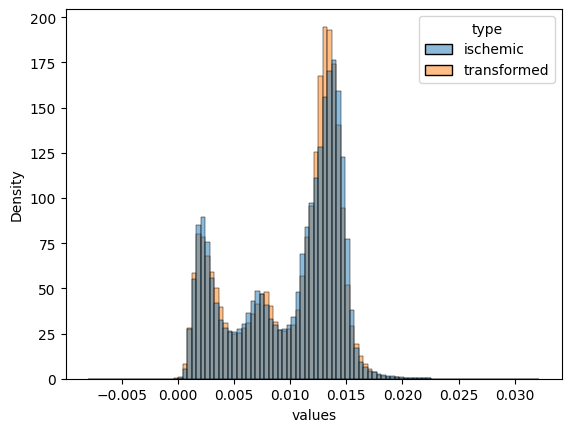

In [10]:
sample_p = DatasetImage([path_p], train=False, config=config)[0]
data_p = sample_p["features"][sample_p["valid_pixels"]].float()
projected_p = projection(data_p).detach()

sample_p2 = DatasetImage([path_p2], train=False, config=config)[0]
data_p2 = sample_p2["features"][sample_p2["valid_pixels"]].float()
projected_p2 = projection(data_p2).detach()

sample_i = DatasetImage([path_i], train=False, config=config)[0]
data_i = sample_i["features"][sample_i["valid_pixels"]].float()

values_i = data_i.numpy().flatten()
values_t = projection(data_p).detach().numpy().flatten()
df_hist = pd.DataFrame({
    "values": np.concatenate([values_i, values_t]),
    "type": ["ischemic"] * len(values_i) + ["transformed"] * len(values_t),
})

sns.histplot(data=df_hist, x="values", hue="type", bins=100, stat="density", common_norm=False)

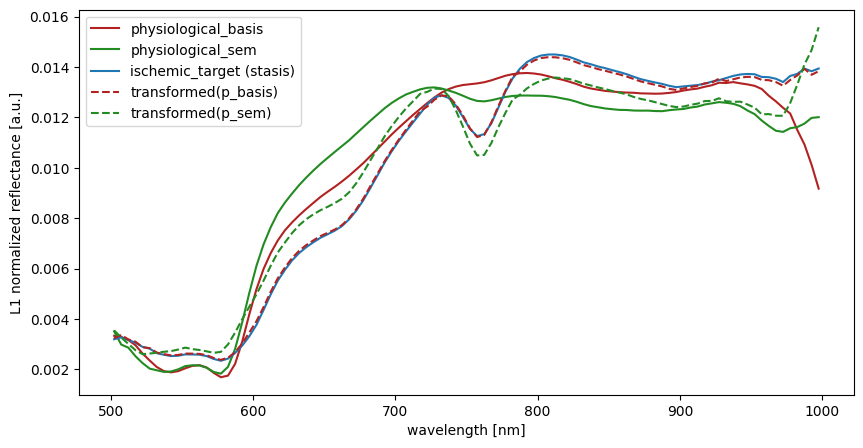

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(wavelengths, data_p.mean(dim=0), c="firebrick", label="physiological_basis")
ax.plot(wavelengths, data_p2.mean(dim=0), c="forestgreen", label="physiological_sem")
ax.plot(wavelengths, data_i.mean(dim=0), label=f"ischemic_target ({path_i.meta('phase_type')})")
ax.plot(wavelengths, projected_p.mean(dim=0), c="firebrick", linestyle="dashed", label="transformed(p_basis)")
ax.plot(wavelengths, projected_p2.mean(dim=0), c="forestgreen", linestyle="dashed", label="transformed(p_sem)")

ax.set_ylabel("L1 normalized reflectance [a.u.]")
ax.set_xlabel("wavelength [nm]")
ax.legend()

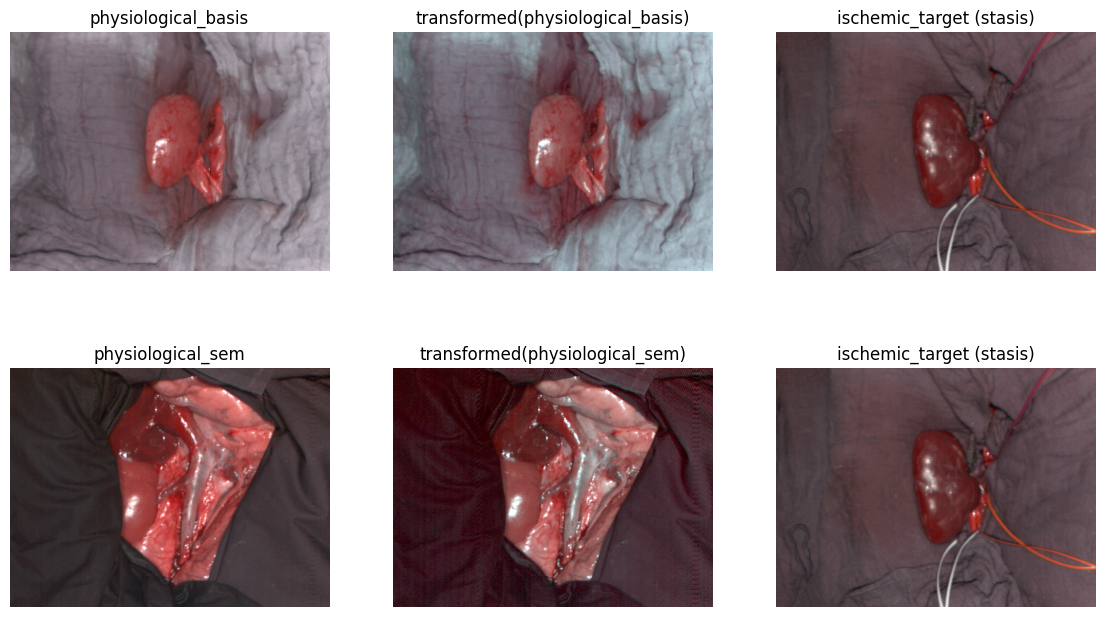

In [12]:
rgb_transformed_p = hsi_to_rgb(
    projection(sample_p["features"].float()).detach().numpy() * np.expand_dims(norm_counts_p, axis=-1)
)
rgb_transformed_p2 = hsi_to_rgb(
    projection(sample_p2["features"].float()).detach().numpy() * np.expand_dims(norm_counts_p2, axis=-1)
)

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(14, 8))

ax1.imshow(path_p.read_rgb_reconstructed())
ax1.set_title("physiological_basis")
ax1.set_axis_off()
ax2.imshow(rgb_transformed_p)
ax2.set_title("transformed(physiological_basis)")
ax2.set_axis_off()
ax3.imshow(path_i.read_rgb_reconstructed())
ax3.set_title(f"ischemic_target ({path_i.meta('phase_type')})")
ax3.set_axis_off()

ax4.imshow(path_p2.read_rgb_reconstructed())
ax4.set_title("physiological_sem")
ax4.set_axis_off()
ax5.imshow(rgb_transformed_p2)
ax5.set_title("transformed(physiological_sem)")
ax5.set_axis_off()
ax6.imshow(path_i.read_rgb_reconstructed())
ax6.set_title(f"ischemic_target ({path_i.meta('phase_type')})")
ax6.set_axis_off()

## Magnitude of Change

In [13]:
diff = torch.abs(sample_p["features"].float() - Normalization()(projection(sample_p["features"].float()).detach()))
diff[~sample_p["valid_pixels"]] = 0

px.imshow(diff.sum(dim=-1))

## Error of all learned projections

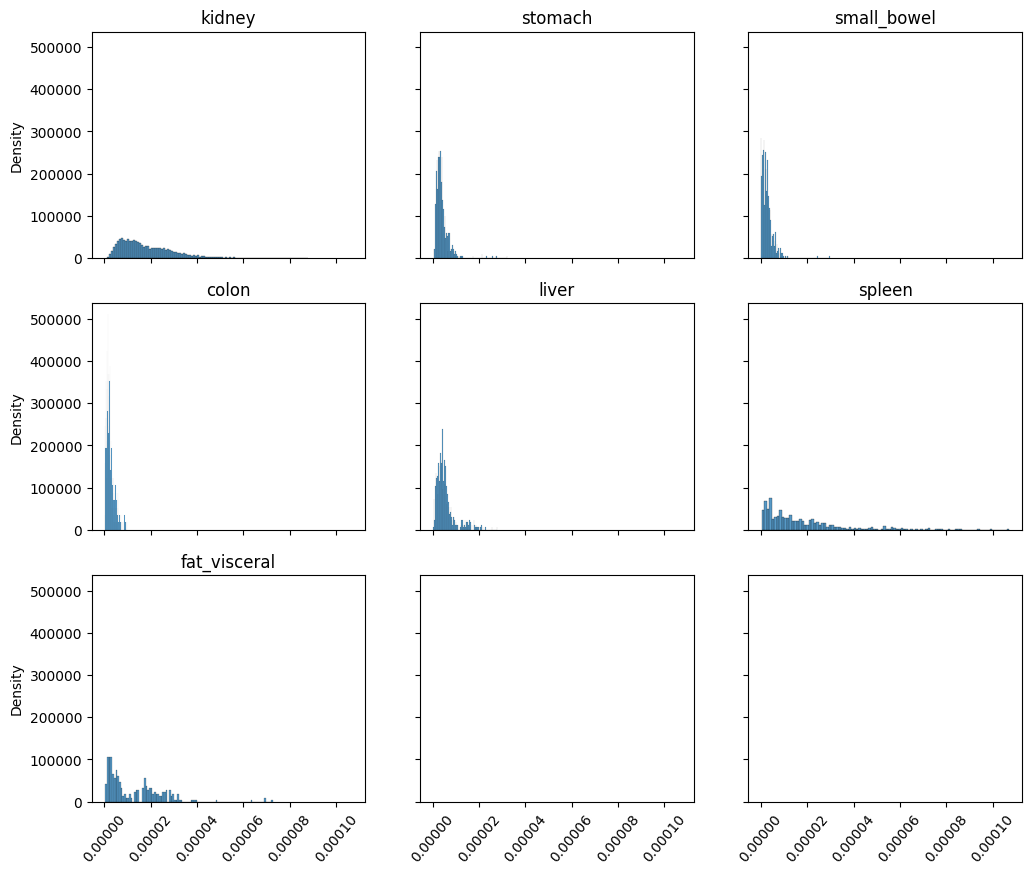

In [14]:
meta_file = settings.results_dir / "projection_matrices" / "kidney=P091,P095,P097,P098+aortic_highlights=70.json"
with meta_file.open("r") as f:
    meta = json.load(f)

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)

for label_name, ax in zip(meta.keys(), axes.flatten(), strict=True):
    losses = [m["loss"] for m in meta[label_name]]

    sns.histplot(x=losses, bins=100, stat="density", common_norm=False, ax=ax)
    ax.set_title(label_name)
    ax.tick_params(axis="x", labelrotation=50)

axes[2, 1].tick_params(axis="x", labelrotation=50)
axes[2, 2].tick_params(axis="x", labelrotation=50)